In [1]:
import numpy as np
import matplotlib.pyplot as py
import pandas as pd

In [2]:
purchase_prices_2017 = pd.read_csv("../data/2017PurchasePricesDec.csv")
begin_inv = pd.read_csv("../data/BegInvFINAL12312016.csv")
end_inv = pd.read_csv("../data/EndInvFINAL12312016.csv")
invoice_purchase = pd.read_csv("../data/InvoicePurchases12312016.csv")
purchase_final = pd.read_csv("../data/PurchasesFINAL12312016.csv")
sales_final = pd.read_csv("../data/SalesFINAL12312016.csv")
                            

In [3]:
purchase_prices_2017

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
0,58,Gekkeikan Black & Gold Sake,12.99,750mL,750,1,9.28,8320,SHAW ROSS INT L IMP LTD
1,62,Herradura Silver Tequila,36.99,750mL,750,1,28.67,1128,BROWN-FORMAN CORP
2,63,Herradura Reposado Tequila,38.99,750mL,750,1,30.46,1128,BROWN-FORMAN CORP
3,72,No. 3 London Dry Gin,34.99,750mL,750,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP
4,75,Three Olives Tomato Vodka,14.99,750mL,750,1,10.94,7245,PROXIMO SPIRITS INC.
...,...,...,...,...,...,...,...,...,...
12256,44917,Ferreira 10-Yr Tawny Port,24.99,750mL,750,2,16.55,90024,VINILANDIA USA
12257,44944,Sanford Santa Rita Pnt Nr,22.99,750mL,750,2,14.93,4425,MARTIGNETTI COMPANIES
12258,45016,Neal One Lane Bridg Cab Svgn,93.99,750mL,750,2,61.43,10754,PERFECTA WINES
12259,46011,Folonari Pnt Nr Venezie,12.99,1500ml,1500,2,8.90,9744,FREDERICK WILDMAN & SONS


In [4]:
purchase_prices_2017.isnull().sum()

Brand             0
Description       1
Price             0
Size              1
Volume            1
Classification    0
PurchasePrice     0
VendorNumber      0
VendorName        0
dtype: int64

In [5]:
purchase_prices_2017[purchase_prices_2017["Size"].isnull()]

,Brand,Description,Price,Size,Volume,Classification,PurchasePrice,VendorNumber,VendorName
7915,4202,NaN,0.0,NaN,NaN,1,11.19,480,BACARDI USA INC


In [6]:
purchase_prices_2017 = purchase_prices_2017.dropna()

In [7]:
print(purchase_prices_2017["Size"].value_counts())

Size
750mL          9823
1500mL          486
1750mL          433
1000mL          427
375mL           318
50mL            276
3000mL          104
187mL            52
500mL            51
187mL 4 Pk       48
5000mL           44
200mL            26
300mL            24
4000mL           16
720mL            11
1500ml           11
100mL             8
50mL 4 Pk         6
750mL 2 Pk        6
250mL 4 Pk        6
180mL             5
20000mL           5
330mL             5
50mL 3 Pk         5
Unknown           4
200mL 3 Pk        4
187mL 3 Pk        4
6000mL            4
50mL 5 Pk         4
375mL 2 Pk        3
200mL 4 Pk        3
250mL             3
18000mL           3
750mL 3 Pk        3
100mL 4 Pk        2
560mL             2
600mL             2
375mL 3 Pk        2
150mL             2
750mL + 3/        2
750mL 6 Pk        2
20mL 5 Pk         1
1100ml            1
650mL             1
750mL  3          1
3750mL            1
19500mL           1
750mL + 4/        1
400mL             1
162.5mL        

In [8]:
print(purchase_prices_2017["Volume"].value_counts())

Volume
750        9840
1500        497
1750        433
1000        428
375         323
50          292
187         104
3000        104
500          51
5000         44
200          34
300          24
4000         16
720          11
100          10
250           9
330           5
20000         5
180           5
Unknown       4
6000          4
18000         3
150           2
600           2
560           2
650           1
20            1
162.5         1
400           1
1100          1
19500         1
3750          1
9000          1
Name: count, dtype: int64


From here we can see thta size contains some 3pk that might disrupt our calcuation and thus we have volume which is more accurate so we will use that , elsewise we will also use a function to remove anything after ml in size to see whther it matches the one im volume or not 

In [4]:
import re

def is_float(value):
    try:
        float(value)
        return True
    except:
        return False

def preprocess_size(size):
    try:
        original_size = size  # Keep a copy of the original size for error reporting
        size = size.lower().strip()  # Convert to lowercase for uniform processing and remove spaces

        quantity = 1

        # Handle '750mL + 2/' format
        if '+' in size:
            size, _ = size.split('+')  # Only consider the main component
            size = size.strip()  # remove any potential spaces
        # Handle '750mL 4 Pk', '187mL 4 Pk', '250mL 4 Pk', '750mL 12 P', and '750mL  3' formats
        elif 'pk' in size or ('p' in size.lower()) or (' ' in size and re.search(r'\d', size.split()[-1])):
            size_parts = re.split(r'\s+', size)  # Split on one or more spaces
            if len(size_parts) >= 2:  # If there are at least two parts
                size = size_parts[0]
                quantity = int(re.sub(r'\D', '', size_parts[1]))  # Keep only the digits
        # Convert gallons and ounces to mL
        elif 'gal' in size:
            size = re.sub(r'gal', '', size).strip()  # remove any potential spaces
            if is_float(size):
                size = float(size) * 3785.41  # Convert gallons to mL
                return size  # If we're here, we have a final result
            else:
                print(f"Size value is not numeric: '{original_size}'")
                return None
        elif 'oz' in size:
            size = re.sub(r'oz', '', size).strip()  # remove any potential spaces
            if is_float(size):
                size = float(size) * 29.5735  # Convert ounces to mL
                return size  # If we're here, we have a final result
            elif '/' in size:
                numerator, denominator = map(float, size.split('/'))  # Split the fraction and convert to float
                size = (numerator / denominator) * 29.5735  # Convert ounces to mL
                return size  # If we're here, we have a final result
            else:
                print(f"Size value is not numeric: '{original_size}'")
                return None

        # Handle '3/100mL' format
        elif '/' in size and 'pk' not in size:
            if 'oz' in size or 'ml' in size or 'l' in size:
                numerator, denominator = size.split('/')[0], re.split(r'[a-z]+', size.split('/')[1])[0]
                size = str(float(numerator) / float(denominator)) + "".join(re.findall(r'[a-z]+', size.split('/')[1]))
            else:
                quantity, size = size.split('/')
                quantity = int(quantity.strip())  # remove any potential spaces
                size = size.strip()  # remove any potential spaces

        # Convert sizes in liters to mL
        if 'ml' in size and is_float(re.sub(r'ml', '', size).strip()):
            size = re.sub(r'ml', '', size).strip()  
            size = float(size) * quantity
        elif 'l' in size and is_float(re.sub(r'l', '', size).strip()):
            size = re.sub(r'l', '', size).strip()  
            size = float(size) * 1000 * quantity
        elif size == 'liter':
            size = 1000.0
        elif is_float(size):  
            size = float(size)
        else:
            print(f"Size value is not numeric: '{original_size}'")
            return None

        return size

    except Exception as e:
        print(f"Error processing size: '{original_size}'. Error: {e}")
        return None  



In [10]:
import re

def is_float(value):
    try:
        float(value)
        return True
    except:
        return False
    
purchase_prices_2017['Size_ml'] = purchase_prices_2017['Size'].apply(preprocess_size)

Size value is not numeric: 'Unknown'
Size value is not numeric: 'Unknown'
Size value is not numeric: 'Unknown'
Size value is not numeric: 'Unknown'


C:\Users\shubh\AppData\Local\Temp\ipykernel_27288\1997160854.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_prices_2017['Size_ml'] = purchase_prices_2017['Size'].apply(preprocess_size)


In [12]:
purchase_prices_2017['profit'] = purchase_prices_2017['Price'] - purchase_prices_2017['PurchasePrice']

C:\Users\shubh\AppData\Local\Temp\ipykernel_27288\1358974905.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  purchase_prices_2017['profit'] = purchase_prices_2017['Price'] - purchase_prices_2017['PurchasePrice']


In [13]:
purchase_prices_2017 = purchase_prices_2017.rename(columns={'Price': 'Sales Price'})

In [14]:
purchase_prices_2017 = purchase_prices_2017.drop(columns=['Size'])


In [15]:
purchase_prices_2017 = purchase_prices_2017.drop(columns=['Volume'])

In [16]:
print(purchase_prices_2017["Size_ml"].value_counts())


Size_ml
750.0      9830
1500.0      503
1000.0      434
1750.0      433
375.0       318
50.0        276
3000.0      104
187.0        52
500.0        51
748.0        48
5000.0       44
200.0        32
300.0        24
4000.0       16
720.0        11
100.0         9
250.0         7
600.0         7
150.0         7
180.0         5
20000.0       5
330.0         5
6000.0        4
2250.0        4
561.0         4
800.0         3
18000.0       3
400.0         3
9000.0        2
4500.0        2
1125.0        2
560.0         2
2000.0        1
650.0         1
162.5         1
1100.0        1
19500.0       1
3750.0        1
Name: count, dtype: int64


In [17]:
purchase_prices_2017

,Brand,Description,Sales Price,Classification,PurchasePrice,VendorNumber,VendorName,Size_ml,profit
0,58,Gekkeikan Black & Gold Sake,12.99,1,9.28,8320,SHAW ROSS INT L IMP LTD,750.0,3.71
1,62,Herradura Silver Tequila,36.99,1,28.67,1128,BROWN-FORMAN CORP,750.0,8.32
2,63,Herradura Reposado Tequila,38.99,1,30.46,1128,BROWN-FORMAN CORP,750.0,8.53
3,72,No. 3 London Dry Gin,34.99,1,26.11,9165,ULTRA BEVERAGE COMPANY LLP,750.0,8.88
4,75,Three Olives Tomato Vodka,14.99,1,10.94,7245,PROXIMO SPIRITS INC.,750.0,4.05
...,...,...,...,...,...,...,...,...,...
12256,44917,Ferreira 10-Yr Tawny Port,24.99,2,16.55,90024,VINILANDIA USA,750.0,8.44
12257,44944,Sanford Santa Rita Pnt Nr,22.99,2,14.93,4425,MARTIGNETTI COMPANIES,750.0,8.06
12258,45016,Neal One Lane Bridg Cab Svgn,93.99,2,61.43,10754,PERFECTA WINES,750.0,32.56
12259,46011,Folonari Pnt Nr Venezie,12.99,2,8.90,9744,FREDERICK WILDMAN & SONS,1500.0,4.09


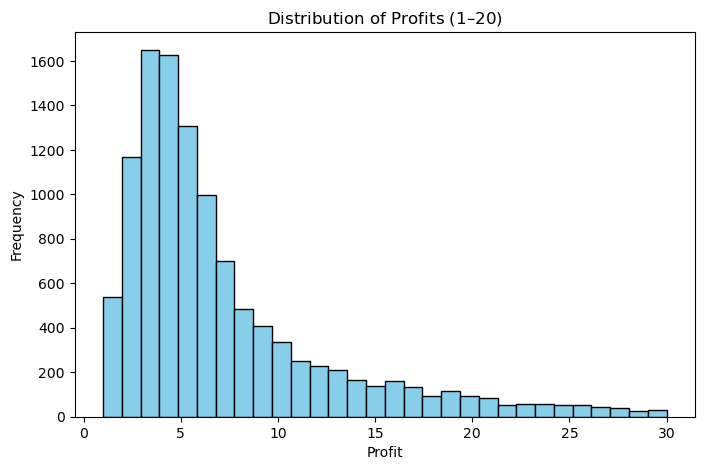

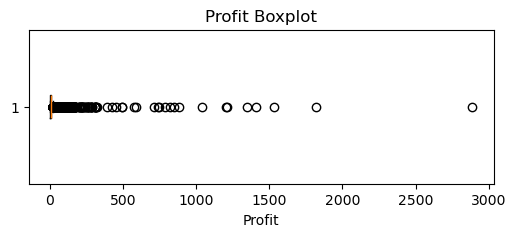

count    12260.000000
mean        12.153924
std         51.456741
min          0.000000
25%          3.540000
50%          5.470000
75%          9.710000
max       2888.870000
Name: profit, dtype: float64


In [21]:
import matplotlib.pyplot as plt

# Histogram focused on $1–$20 profit range
plt.figure(figsize=(8,5))
plt.hist(purchase_prices_2017['profit'], bins=30, color='skyblue', edgecolor='black', range=(1, 30))
plt.title('Distribution of Profits ($1–$20)')
plt.xlabel('Profit')
plt.ylabel('Frequency')
plt.show()

# Boxplot for profit
plt.figure(figsize=(6,2))
plt.boxplot(purchase_prices_2017['profit'], vert=False)
plt.title('Profit Boxplot')
plt.xlabel('Profit')
plt.show()

# Print summary statistics
print(purchase_prices_2017['profit'].describe())



In [20]:
max_profit_row = purchase_prices_2017.loc[purchase_prices_2017['profit'].idxmax()]
print(max_profit_row)

Brand                                    2693
Description           Glen Grant 50 Yr Scotch
Sales Price                           13999.9
Classification                              1
PurchasePrice                        11111.03
VendorNumber                            11567
VendorName        CAMPARI AMERICA            
Size_ml                                 750.0
profit                                2888.87
Name: 9162, dtype: object


In [23]:
# Save the DataFrame to a CSV file in the data folder
purchase_prices_2017.to_csv("../data/self preprocessed/sales_and_purchase_price.csv", index=False)

In [24]:
begin_inv

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,startDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,8,12.99,2016-01-01
1,1_HARDERSFIELD_60,1,HARDERSFIELD,60,Canadian Club 1858 VAP,750mL,7,10.99,2016-01-01
2,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,6,36.99,2016-01-01
3,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,3,38.99,2016-01-01
4,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,6,34.99,2016-01-01
...,...,...,...,...,...,...,...,...,...
206524,79_BALLYMENA_46985,79,BALLYMENA,46985,Rodney Strong Cab Svgn Alexa,750mL,13,22.99,2016-01-01
206525,79_BALLYMENA_47014,79,BALLYMENA,47014,Juan Gil Jumilla Rd,750mL,13,13.99,2016-01-01
206526,79_BALLYMENA_47090,79,BALLYMENA,47090,Napa Cellars Cab Svgn Napa,750mL,19,23.99,2016-01-01
206527,79_BALLYMENA_90011,79,BALLYMENA,90011,Ch Pichon Longville 12 Pauil,750mL,12,144.99,2016-01-01


In [25]:
end_inv

,InventoryId,Store,City,Brand,Description,Size,onHand,Price,endDate
0,1_HARDERSFIELD_58,1,HARDERSFIELD,58,Gekkeikan Black & Gold Sake,750mL,11,12.99,2016-12-31
1,1_HARDERSFIELD_62,1,HARDERSFIELD,62,Herradura Silver Tequila,750mL,7,36.99,2016-12-31
2,1_HARDERSFIELD_63,1,HARDERSFIELD,63,Herradura Reposado Tequila,750mL,7,38.99,2016-12-31
3,1_HARDERSFIELD_72,1,HARDERSFIELD,72,No. 3 London Dry Gin,750mL,4,34.99,2016-12-31
4,1_HARDERSFIELD_75,1,HARDERSFIELD,75,Three Olives Tomato Vodka,750mL,7,14.99,2016-12-31
...,...,...,...,...,...,...,...,...,...
224484,81_PEMBROKE_90087,81,PEMBROKE,90087,Ch Mouton Rothschild 12 Paui,750mL,3,469.99,2016-12-31
224485,81_PEMBROKE_90088,81,PEMBROKE,90088,Ch Le Petite Mouton 12 Pauil,750mL,3,134.99,2016-12-31
224486,81_PEMBROKE_90089,81,PEMBROKE,90089,Ch Lynch Bages 12 Pauillac,750mL,3,119.99,2016-12-31
224487,81_PEMBROKE_90090,81,PEMBROKE,90090,Ch Lafite Rothschild 12,750mL,3,649.99,2016-12-31


In [26]:
invoice_purchase


,VendorNumber,VendorName,InvoiceDate,PONumber,PODate,PayDate,Quantity,Dollars,Freight,Approval
0,105,ALTAMAR BRANDS LLC,2016-01-04,8124,2015-12-21,2016-02-16,6,214.26,3.47,NaN
1,4466,AMERICAN VINTAGE BEVERAGE,2016-01-07,8137,2015-12-22,2016-02-21,15,140.55,8.57,NaN
2,388,ATLANTIC IMPORTING COMPANY,2016-01-09,8169,2015-12-24,2016-02-16,5,106.60,4.61,NaN
3,480,BACARDI USA INC,2016-01-12,8106,2015-12-20,2016-02-05,10100,137483.78,2935.20,NaN
4,516,BANFI PRODUCTS CORP,2016-01-07,8170,2015-12-24,2016-02-12,1935,15527.25,429.20,NaN
...,...,...,...,...,...,...,...,...,...,...
5538,9622,WEIN BAUER INC,2017-01-06,13626,2016-12-21,2017-02-10,90,1563.00,8.60,NaN
5539,9625,WESTERN SPIRITS BEVERAGE CO,2017-01-10,13661,2016-12-23,2017-02-18,4617,37300.48,186.50,NaN
5540,3664,WILLIAM GRANT & SONS INC,2017-01-02,13643,2016-12-22,2017-02-04,9848,202815.78,932.95,NaN
5541,9815,WINE GROUP INC,2017-01-03,13602,2016-12-20,2017-02-08,24747,149007.56,819.54,NaN


In [27]:
purchase_final

,InventoryId,Store,Brand,Description,Size,VendorNumber,VendorName,PONumber,PODate,ReceivingDate,InvoiceDate,PayDate,PurchasePrice,Quantity,Dollars,Classification
0,69_MOUNTMEND_8412,69,8412,Tequila Ocho Plata Fresno,750mL,105,ALTAMAR BRANDS LLC,8124,2015-12-21,2016-01-02,2016-01-04,2016-02-16,35.71,6,214.26,1
1,30_CULCHETH_5255,30,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,4,37.40,1
2,34_PITMERDEN_5215,34,5215,TGI Fridays Long Island Iced,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-02,2016-01-07,2016-02-21,9.41,5,47.05,1
3,1_HARDERSFIELD_5255,1,5255,TGI Fridays Ultimte Mudslide,1.75L,4466,AMERICAN VINTAGE BEVERAGE,8137,2015-12-22,2016-01-01,2016-01-07,2016-02-21,9.35,6,56.10,1
4,76_DONCASTER_2034,76,2034,Glendalough Double Barrel,750mL,388,ATLANTIC IMPORTING COMPANY,8169,2015-12-24,2016-01-02,2016-01-09,2016-02-16,21.32,5,106.60,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2372469,49_GARIGILL_22298,49,22298,Zorvino Vyds Sangiovese,750mL,90058,ZORVINO VINEYARDS,13593,2016-12-19,2016-12-28,2017-01-09,2017-02-06,8.06,12,96.72,2
2372470,1_HARDERSFIELD_19556,1,19556,Zorvino Bacca Z Blackberry,750mL,90058,ZORVINO VINEYARDS,13593,2016-12-19,2016-12-27,2017-01-09,2017-02-06,9.39,12,112.68,2
2372471,66_EANVERNESS_22297,66,22297,Zorvino Vyds Pearz,750mL,90058,ZORVINO VINEYARDS,13593,2016-12-19,2016-12-26,2017-01-09,2017-02-06,6.75,12,81.00,2
2372472,69_MOUNTMEND_19557,69,19557,Zorvino Fragole Z Strawberry,750mL,90058,ZORVINO VINEYARDS,13593,2016-12-19,2016-12-26,2017-01-09,2017-02-06,9.39,12,112.68,2


In [5]:
sales_final

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,4,51.80,12.95,2/12/2016,750,2,0.45,2000,SOUTHERN WINE & SPIRITS NE
1048571,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,8,103.60,12.95,2/13/2016,750,2,0.90,2000,SOUTHERN WINE & SPIRITS NE
1048572,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,1,12.95,12.95,2/19/2016,750,2,0.11,2000,SOUTHERN WINE & SPIRITS NE
1048573,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,3,38.85,12.95,2/22/2016,750,2,0.34,2000,SOUTHERN WINE & SPIRITS NE


In [6]:
sales_final["Size"].value_counts()

Size
750mL         593098
1.75L         172222
50mL          101816
1.5L           67189
375mL          52659
Liter          18946
5L             12362
3L             11005
187mL 4 Pk      2906
500mL           2543
200mL           2267
100mL           2238
4L              1486
50mL 5 Pk       1411
187mL           1234
100mL 4 Pk       988
50mL 4 Pk        725
750mL 2 Pk       420
300mL            414
50mL 3 Pk        384
3/100mL          356
200mL 4 Pk       309
5.0 Oz           223
187mL 3 Pk       204
250mL 4 Pk       175
375mL 2 Pk       175
720mL            170
330mL            122
750mL + 2/       107
250mL            105
200mL 3 Pk        86
180mL             55
750mL 3 Pk        49
750mL + 3/        48
18L               27
50mL 12 Pk        21
375mL 3 Pk        18
750mL 4 Pk         8
22.0 Oz            3
20L                1
Name: count, dtype: int64

In [7]:
sales_final["Size_ml"] = sales_final["Size"].apply(preprocess_size)

In [8]:
sales_final

,InventoryId,Store,Brand,Description,Size,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Volume,Classification,ExciseTax,VendorNo,VendorName,Size_ml
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/1/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,2,32.98,16.49,1/2/2016,750,1,1.57,12546,JIM BEAM BRANDS COMPANY,750.0
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,16.49,16.49,1/3/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,750mL,1,14.49,14.49,1/8/2016,750,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,375mL 2 Pk,2,69.98,34.99,1/9/2016,375,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,4,51.80,12.95,2/12/2016,750,2,0.45,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048571,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,8,103.60,12.95,2/13/2016,750,2,0.90,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048572,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,1,12.95,12.95,2/19/2016,750,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048573,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,750mL,3,38.85,12.95,2/22/2016,750,2,0.34,2000,SOUTHERN WINE & SPIRITS NE,750.0


In [9]:
sales_final = sales_final.drop(columns=["Volume"])
sales_final = sales_final.drop(columns=["Size"])



In [10]:
sales_final

,InventoryId,Store,Brand,Description,SalesQuantity,SalesDollars,SalesPrice,SalesDate,Classification,ExciseTax,VendorNo,VendorName,Size_ml
0,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,1,16.49,16.49,1/1/2016,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
1,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,2,32.98,16.49,1/2/2016,1,1.57,12546,JIM BEAM BRANDS COMPANY,750.0
2,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,1,16.49,16.49,1/3/2016,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
3,1_HARDERSFIELD_1004,1,1004,Jim Beam w/2 Rocks Glasses,1,14.49,14.49,1/8/2016,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
4,1_HARDERSFIELD_1005,1,1005,Maker's Mark Combo Pack,2,69.98,34.99,1/9/2016,1,0.79,12546,JIM BEAM BRANDS COMPANY,750.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,4,51.80,12.95,2/12/2016,2,0.45,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048571,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,8,103.60,12.95,2/13/2016,2,0.90,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048572,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,1,12.95,12.95,2/19/2016,2,0.11,2000,SOUTHERN WINE & SPIRITS NE,750.0
1048573,19_WINTERVALE_39384,19,39384,F Coppola Diamond Pnt Nr,3,38.85,12.95,2/22/2016,2,0.34,2000,SOUTHERN WINE & SPIRITS NE,750.0


In [11]:
sales_final.isnull().sum()

InventoryId       0
Store             0
Brand             0
Description       0
SalesQuantity     0
SalesDollars      0
SalesPrice        0
SalesDate         0
Classification    0
ExciseTax         0
VendorNo          0
VendorName        0
Size_ml           0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 13 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   InventoryId     1048575 non-null  object 
 1   Store           1048575 non-null  int64  
 2   Brand           1048575 non-null  int64  
 3   Description     1048575 non-null  object 
 4   SalesQuantity   1048575 non-null  int64  
 5   SalesDollars    1048575 non-null  float64
 6   SalesPrice      1048575 non-null  float64
 7   SalesDate       1048575 non-null  object 
 8   Classification  1048575 non-null  int64  
 9   ExciseTax       1048575 non-null  float64
 10  VendorNo        1048575 non-null  int64  
 11  VendorName      1048575 non-null  object 
 12  Size_ml         1048575 non-null  float64
dtypes: float64(4), int64(5), object(4)
memory usage: 104.0+ MB
None
              Store         Brand  SalesQuantity  SalesDollars    SalesPrice  \
count  1.048575e+06  1.048575e+06

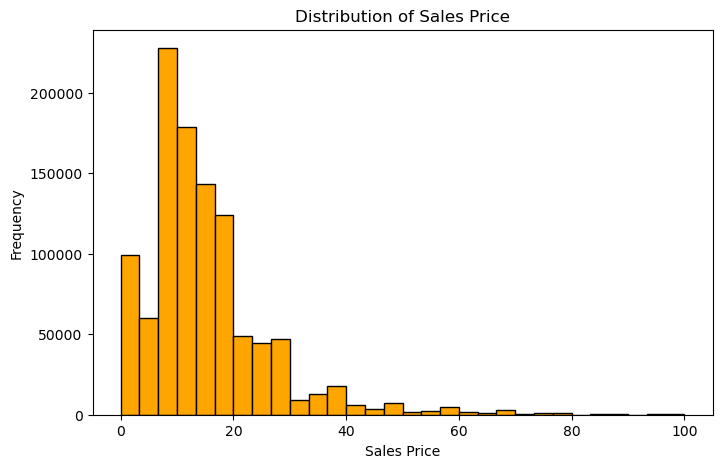

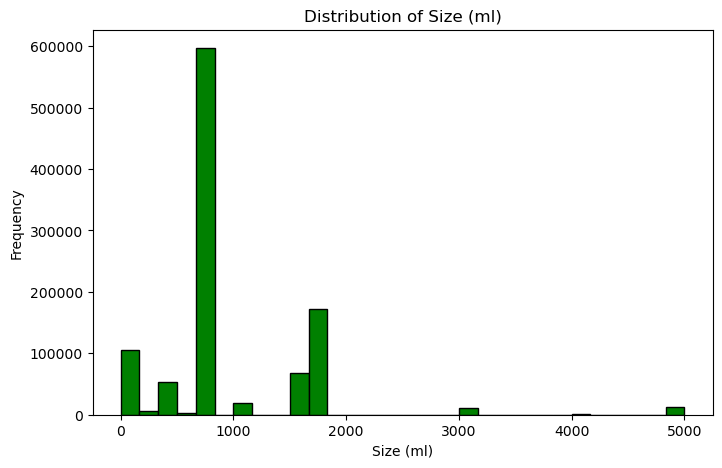


Value counts for InventoryId:
InventoryId
13_TARMSWORTH_8064    57
13_TARMSWORTH_3837    56
14_BROMWICH_8910      56
13_TARMSWORTH_1892    56
10_HORNSEY_4798       56
Name: count, dtype: int64

Value counts for Description:
Description
Smirnoff 80 Proof          7123
Capt Morgan Spiced Rum     7057
Jack Daniels No 7 Black    7014
Jagermeister Liqueur       6763
Kahlua                     6527
Name: count, dtype: int64

Value counts for SalesDate:
SalesDate
1/29/2016    54142
1/30/2016    47256
1/23/2016    44792
1/22/2016    44276
1/15/2016    43946
Name: count, dtype: int64

Value counts for VendorName:
VendorName
DIAGEO NORTH AMERICA INC       125869
JIM BEAM BRANDS COMPANY         94057
MARTIGNETTI COMPANIES           76251
CONSTELLATION BRANDS INC        70792
E & J GALLO WINERY              65240
Name: count, dtype: int64


In [15]:
import matplotlib.pyplot as plt

# Show basic info
print(sales_final.info())
print(sales_final.describe())

# Plot histogram of Sales Price if available
if 'SalesPrice' in sales_final.columns:
    plt.figure(figsize=(8,5))
    plt.hist(sales_final['SalesPrice'], bins=30, color='orange', edgecolor='black', range=(0,100))
    plt.title('Distribution of Sales Price')
    plt.xlabel('Sales Price')
    plt.ylabel('Frequency')
    plt.show()

# Plot histogram of Size_ml if available
if 'Size_ml' in sales_final.columns:
    plt.figure(figsize=(8,5))
    plt.hist(sales_final['Size_ml'].dropna(), bins=30, color='green', edgecolor='black',range=(0,5000))
    plt.title('Distribution of Size (ml)')
    plt.xlabel('Size (ml)')
    plt.ylabel('Frequency')
    plt.show()

# Show value counts for categorical columns if any
for col in sales_final.select_dtypes(include='object').columns:
    print(f"\nValue counts for {col}:")
    print(sales_final[col].value_counts().head())

Brand  Description                   SalesPrice
8111   Smirnoff 80 Proof             0.99          28544
1892   Yukon Jack                    0.99          23121
4261   Capt Morgan Spiced Rum        21.99         20185
3606   Smirnoff Raspberry Vodka      0.99          19200
5111   Dr McGillicuddy's Mentholmnt  0.99          18411
3837   Skyy Vodka                    0.99          14057
4135   Smirnoff Blueberry Vodka      0.99          12477
4157   Smirnoff Green Apple Vodka    0.99          12102
3545   Ketel One Vodka               29.99         11189
5491   Rumpleminze                   1.99          11027
Name: SalesQuantity, dtype: int64


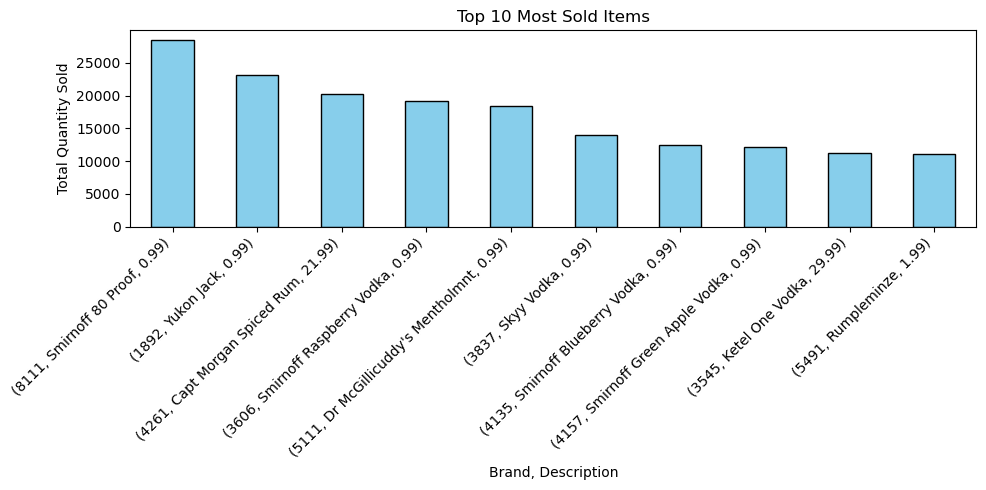

In [17]:
top_sold = sales_final.groupby(['Brand', 'Description' , 'SalesPrice'])['SalesQuantity'].sum().sort_values(ascending=False).head(10)
print(top_sold)

# Optional: Bar plot for visualization
top_sold.plot(kind='bar', figsize=(10,5), color='skyblue', edgecolor='black')
plt.title('Top 10 Most Sold Items')
plt.ylabel('Total Quantity Sold')
plt.xlabel('Brand, Description')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [18]:
# Save the sales_final DataFrame to a CSV file in the data folder
sales_final.to_csv("../data/self preprocessed/sales_final.csv", index=False)